# Work with Transformers

In [2]:
!pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# !pip install git+https://github.com/huggingface/transformers.git
import transformers

GITHUB https://github.com/huggingface/transformers


See examples of how to do comon tasks:
https://github.com/huggingface/transformers/tree/master/examples


All available Hugging Face models you can find here:
https://huggingface.co/models


The library is build around three types of classes for each model:

* ***model classes*** e.g., BertModel which are 20+ PyTorch models (torch.nn.Modules) that work with the pretrained weights provided in the library. In TF2, these are tf.keras.Model.

* ***configuration classes*** which store all the parameters required to build a model, e.g., BertConfig. You don’t always need to instantiate these your-self. In particular, if you are using a pretrained model without any modification, creating the model will automatically take care of instantiating the configuration (which is part of the model)

* ***tokenizer classes*** which store the vocabulary for each model and provide methods for encoding/decoding strings in a list of token embeddings indices to be fed to a model, e.g., BertTokenizer

All these classes can be instantiated from pretrained instances and saved locally using two methods:

* *from_pretrained()* let you instantiate a model/configuration/tokenizer from a pretrained version either provided by the library itself (currently 27 models are provided as listed here) or stored locally (or on a server) by the user,

* *save_pretrained()* let you save a model/configuration/tokenizer locally so that it can be reloaded using from_pretrained().


In [ ]:
from transformers import pipeline

# Allocate a pipeline for question-answering
question_answerer = pipeline('question-answering')
question_answerer({
     'question': 'What is the name of the repository ?',
     'context': 'Pipeline have been included in the huggingface/transformers repository'
})

{'answer': 'huggingface/transformers',
 'end': 59,
 'score': 0.5135958790779114,
 'start': 35}

In [ ]:
from transformers import pipeline

# Allocate a pipeline for sentiment-analysis
classifier = pipeline('sentiment-analysis')
classifier('We are very happy to use transformers repository.')

[{'label': 'POSITIVE', 'score': 0.99924635887146}]

### Tokenizers. Byte Pair Encoding 

Neural network models need to process text somehow. First, it is required to **encode** text as numbers with ids, since the tensor operations act on numbers. After, if the output of the network are words, it is required to **decode** the predicted tokens ids back to text.

Instead of training a machine to lookup fixed dictionaries, we want to teach machines to recognize and “read” text in such a way that it can learn from this action itself. Machines don’t have human knowledge, they need to be told how to break text into standard units to process it. They do this using a system called **tokenization**, where sequences of text are broken into smaller parts, or “tokens”, and then fed as input into a DL NLP model.

There are many problems and practical issues with tokenization:
* how large our *vocabulary* of words, `vocab_size`, should be and as a result consider memory limitations (If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence)
* what to do with unique rare words and missing tokens (the problem of vocabulary coverage)
* what to do with languages without spaces between words?

We want a system that is able to deal with missing tokens without needing an infinite vocabulary. We want a tokenization scheme that deals with an infinite potential vocabulary via a finite list of known words. Also, we don’t want the extra complexity of breaking everything into single characters since character-level tokenization can lose some of the meaning and semantic niceties of the word level.

We need a compromise, a hybrid between word-level and character-level tokenization called ***subword tokenization***. 

Three main types of subword tokenizers used in Hugging Face library:
* BPE (https://arxiv.org/pdf/1508.07909.pdf)
* WordPiece
* SentencePiece(https://www.aclweb.org/anthology/D18-2012.pdf) unicode characters are grouped together using either a [unigram language model](https://www.aclweb.org/anthology/P18-1007.pdf)

Read about tokenizers you can for example here:
* https://blog.floydhub.com/tokenization-nlp/#bpe
* https://huggingface.co/transformers/tokenizer_summary.html
* https://towardsdatascience.com/comparing-transformer-tokenizers-686307856955

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# subwords:'gp', '##u'
print(tokenizer.tokenize("I have a new GPU!"))


['i', 'have', 'a', 'new', 'gp', '##u', '!']


The `T5Tokenizer` uses SentencePiece for example, where the
`"▁"` character was included in the vocabulary. Decoding with SentencePiece is very easy since all tokens can just be
concatenated and `"▁"` is replaced by a space.

All transformers models in the library that use SentencePiece use it in combination with unigram. Examples of models
using SentencePiece are [ALBERT](https://huggingface.co/transformers/model_doc/albert.html), [XLNet](https://huggingface.co/transformers/model_doc/xlnet.html), [Marian](https://huggingface.co/transformers/model_doc/marian.html), and [T5](https://huggingface.co/transformers/model_doc/t5.html).

In [ ]:
# Install SentencePiece library https://github.com/google/sentencepiece#installation
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 25.0MB/s 


In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/t5-small-ssm")
tokenizer.tokenize("Don't you love 🤗 Transformers? We sure do.")

['▁Don',
 "'",
 't',
 '▁you',
 '▁love',
 '▁',
 '🤗',
 '▁Transformer',
 's',
 '?',
 '▁We',
 '▁sure',
 '▁do',
 '.']

### BERT example 

preparing a tokenized input (a list of token embeddings indices to be fed to Bert) from a text string 

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

INFO:filelock:Lock 139754749659728 acquired on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 139754749659728 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Use `BertForMaskedLM` for predicting MASK token.

In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
print(predicted_index)
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
print(predicted_token)
assert predicted_token == 'henson'

INFO:filelock:Lock 139754750202832 acquired on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.637c6035640bacb831febcc2b7f7bee0a96f9b30c2d7e9ef84082d9f252f3170.lock


INFO:filelock:Lock 139754750202832 released on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.637c6035640bacb831febcc2b7f7bee0a96f9b30c2d7e9ef84082d9f252f3170.lock


INFO:filelock:Lock 139754749045840 acquired on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


INFO:filelock:Lock 139754749045840 released on /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f.lock


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


27227
henson


In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    # Transformers models always output tuples.
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]

print(encoded_layers)
# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
assert tuple(encoded_layers.shape) == (1, len(indexed_tokens), model.config.hidden_size)

tensor([[[-0.5570,  0.2839, -0.6436,  ..., -0.7274,  0.4557,  0.6204],
         [-1.1572,  0.0354,  0.0355,  ...,  0.0591,  0.1097, -0.3150],
         [ 0.1008, -0.5286, -0.4688,  ..., -0.0431,  0.4889,  0.4134],
         ...,
         [ 0.1948,  0.0761,  0.2893,  ..., -0.0807,  0.7071,  0.0502],
         [-0.1119,  0.0714,  0.6101,  ...,  0.4044,  0.1614, -0.3569],
         [ 0.8296,  0.2729, -0.3090,  ...,  0.2452, -0.3581, -0.1970]]],
       device='cuda:0')


##### Check sentence embeddings of the model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

sentences = [
    "Hey, how are you today?",
    "I hope you have life-work balances.",
]

# tokenize a batch of inputs. "pt" means [p]y[t]orch tensors
tokens_info = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

for key in tokens_info:
    print(key, tokens_info[key])

print("Detokenized:")
for i in range(2):
    print(tokenizer.decode(tokens_info['input_ids'][i]))

# apply the model to get embeddings
with torch.no_grad():
    token_embeddings, sentence_embedding = model(**tokens_info)

print("Token: ", token_embeddings)
print("Sentence: ", sentence_embedding)

# See on one sentence:
input_sentence = torch.tensor(tokenizer.encode("My awesome sentence")).unsqueeze(0)
print(tokenizer.encode("My awesome sentence"))
out = model(input_sentence)
embeddings_of_last_layer = out[0]
print(embeddings_of_last_layer.shape)
cls_embeddings = embeddings_of_last_layer[0]
# [CLS] 
cls_embeddings

input_ids tensor([[ 101, 4931, 1010, 2129, 2024, 2017, 2651, 1029,  102,    0,    0,    0],
        [ 101, 1045, 3246, 2017, 2031, 2166, 1011, 2147, 5703, 2015, 1012,  102]])
token_type_ids tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Detokenized:
[CLS] hey, how are you today? [SEP] [PAD] [PAD] [PAD]
[CLS] i hope you have life - work balances. [SEP]
Token:  last_hidden_state
Sentence:  pooler_output
[101, 2026, 12476, 6251, 102]
torch.Size([1, 5, 768])


tensor([[ 0.0051,  0.1006,  0.0311,  ..., -0.0059,  0.0928, -0.0599],
        [-0.3759, -0.0244,  0.4438,  ..., -0.2665,  0.5087,  0.2046],
        [-0.0235, -0.1542, -0.1254,  ...,  0.2556, -0.1367, -0.1162],
        [-0.3472, -0.1840, -0.4172,  ...,  0.6273, -0.3594, -0.5472],
        [ 0.7600, -0.0073, -0.1210,  ..., -0.0728, -0.7092, -0.3475]],
       grad_fn=<SelectBackward>)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."

marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

print(list(tokenizer.vocab.keys())[5000:5010])

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print(tup)

segments_ids = [1] * len(tokenized_text)
print(segments_ids)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# Put the model in "evaluation" mode, meaning feed-forward operation.
model = model.eval()

# Predict hidden states features for each layer
with torch.no_grad():
    out = model(tokens_tensor, segments_tensors)

encoded_layers = out[2]

['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']
['##iam', '##υ', 'blown', 'applicant', '##∧', 'doubted', '##ages', 'pyrenees', 'queue', 'paralympic']
('[CLS]', 101)
('after', 2044)
('stealing', 11065)
('money', 2769)
('from', 2013)
('the', 1996)
('bank', 2924)
('vault', 11632)
(',', 1010)
('the', 1996)
('bank', 2924)
('robber', 27307)
('was', 2001)
('seen', 2464)
('fishing', 5645)
('on', 2006)
('the', 1996)
('mississippi', 5900)
('river', 2314)
('bank', 2924)
('.', 1012)
('[SEP]', 102)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


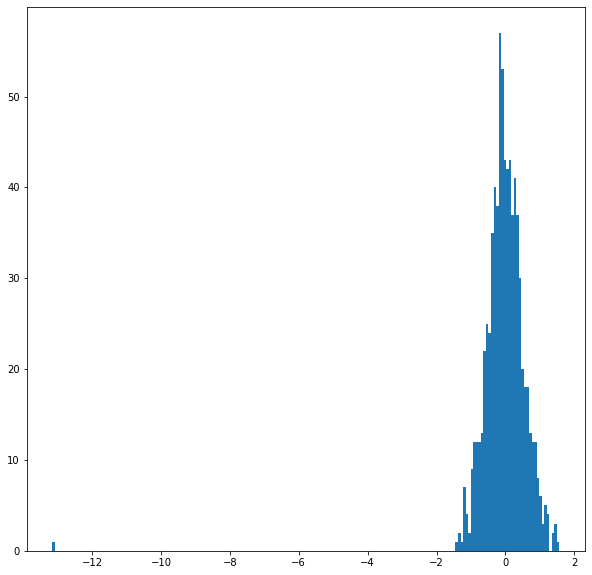

In [ ]:
import matplotlib.pyplot as plt
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Convert the hidden state embeddings into single token vectors

# Holds the list of 12 layer embeddings for each token
# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  # Holds 12 layers of hidden states for each token 
    hidden_layers = [] 
  
  # For each of the 12 layers...
    for layer_i in range(len(encoded_layers)):
    
    # Lookup the vector for `token_i` in `layer_i`
        vec = encoded_layers[layer_i][batch_i][token_i]
        hidden_layers.append(vec)
    
    token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))

Number of tokens in sequence: 22
Number of layers per token: 13


In [ ]:
concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]

summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]
sentence_embedding = torch.mean(encoded_layers[11], 1)
print ("Our final sentence embedding vector of shape:"), sentence_embedding[0].shape[0]

Our final sentence embedding vector of shape:


(None, 768)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare "bank" as in "bank robber" to "bank" as in "river bank"
different_bank = cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[19].reshape(1,-1))[0][0]

# Compare "bank" as in "bank robber" to "bank" as in "bank vault" 
same_bank = cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[6].reshape(1,-1))[0][0]

print("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault':",  same_bank)
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank':",  different_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault': 0.9386393
Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank': 0.6932363


##### Fine tune BERT on classification task

In [3]:
# !pip install transformers==4.0.1
# !pip install sentencepiece==0.1.94
import random
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM

In [4]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased")
model.to(device)

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
train_data_df = pd.read_json("train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("val.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = [1 if ans else 0 for ans in train_data_df.label.values]
answers_train = train_data_df.label.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = [1 if ans else 0 for ans in dev_data_df.label.values]

# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [12]:
# Building Dataloaders
batch_size = 4

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [13]:
epochs = 10
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for epoch in tqdm(range(epochs), desc="Epoch"):
  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 # Cumulative accuracy
  model.eval()

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
    
    with torch.no_grad():        
        outputs = model(input_ids, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  print('Epoch', epoch)
  print('Accuracy:', round(epoch_dev_accuracy, 4),'\n')
  dev_acc_values.append(epoch_dev_accuracy)

Epoch:  10%|█         | 1/10 [03:55<35:18, 235.43s/it]

Epoch 0
Accuracy: 0.5704 



Epoch:  20%|██        | 2/10 [07:49<31:20, 235.12s/it]

Epoch 1
Accuracy: 0.6808 



Epoch:  30%|███       | 3/10 [11:42<27:21, 234.48s/it]

Epoch 2
Accuracy: 0.71 



Epoch:  40%|████      | 4/10 [15:34<23:21, 233.62s/it]

Epoch 3
Accuracy: 0.71 



Epoch:  50%|█████     | 5/10 [19:24<19:23, 232.65s/it]

Epoch 4
Accuracy: 0.6869 



Epoch:  60%|██████    | 6/10 [23:14<15:27, 231.81s/it]

Epoch 5
Accuracy: 0.6942 



Epoch:  70%|███████   | 7/10 [27:04<11:33, 231.16s/it]

Epoch 6
Accuracy: 0.6517 



Epoch:  80%|████████  | 8/10 [30:54<07:41, 230.72s/it]

Epoch 7
Accuracy: 0.6456 



Epoch:  90%|█████████ | 9/10 [34:43<03:50, 230.38s/it]

Epoch 8
Accuracy: 0.5959 



Epoch: 100%|██████████| 10/10 [38:33<00:00, 231.31s/it]

Epoch 9
Accuracy: 0.6614 



### GPT3 examples Russian

You can test, generate and finetune Russian GPT2,3 models
See them [here](https://github.com/sberbank-ai/ru-gpts)

In [ ]:
!git clone  https://github.com/sberbank-ai/ru-gpts

fatal: destination path 'ru-gpts' already exists and is not an empty directory.


In [ ]:
import numpy as np
import torch
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

Some usefull parameters of generation:

* top_p - if set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
* top_k - the number of highest probability vocabulary tokens to keep for top-k-filtering
* temperature - value used to module the next token probabilities

You can always change decoding methods: Greedy search, Beam search, Top-K sampling* and Top-p sampling.

*sampling means randomly picking the next word w_t according to its conditional probability distribution.

Read about different inference techniques https://huggingface.co/blog/how-to-generate and parameters.


In [ ]:
def load_tokenizer_and_model(model_name_or_path):
  return GPT2Tokenizer.from_pretrained(model_name_or_path), GPT2LMHeadModel.from_pretrained(model_name_or_path).cuda()


def generate(
    model, tok, text,
    do_sample=True, max_length=100, repetition_penalty=1.5,
    top_k=10, top_p=0.95, temperature=1,
    num_beams=None,
    no_repeat_ngram_size=3
    ):
  input_ids = tok.encode(text, return_tensors="pt").cuda()
  out = model.generate(
      input_ids.cuda(),
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      do_sample=do_sample,
      top_k=top_k, top_p=top_p, temperature=temperature,
      num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size
      )
  return list(map(tok.decode, out))

In [ ]:
tokenizer, model = load_tokenizer_and_model("sberbank-ai/rugpt3large_based_on_gpt2")
generated = generate(model, tokenizer, "На словах ты Лев Толстой, а  ", num_beams=10)
generated[0]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'На словах ты Лев Толстой, а   на  деле  -  не  Толстой,  а  графоман.  Ты  пишешь  о  том,  что  у  тебя  нет  ни  одного  настоящего  друга,  и  в  то  же  время  предлагаешь  мне  стать  твоим  другом.  Если  бы  я  был  таким,  каким  ты  меня  считаешь,  то,  может  быть,  мы  с  тобой  стали бы  друзьями.  Но  если  бы я был таким, как ты меня считаешь, то, может быть, мы с тобой никогда не стали бы друзьями.\n\nЛев Толстой.\n'

In [ ]:
generated = generate(model, tokenizer, 
  "Кошка => Кошки\n\
  Собака => Собаки\n\
  Коза => Козы\n\
  Овца => Овцы\n \
  Петух => Петухи\n \
  Волк => Волки\n \
  Зебра => ", num_beams=2
)
generated[0]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Кошка => Кошки\n  Собака => Собаки\n  Коза => Козы\n  Овца => Овцы\n   Петух => Петухи\n   Волк => Волки\n   Зебра =>  Зебры\n  Зайцы => Зайцы\n  Свиньи => Свиные\n  Черепахи => Черепах\n  Змеи => Змеи\n  Лошади => Лошади\n  Ол'